In [6]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import timeit

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler
# # from sklearn.compose import ColumnTransformer
# # from sklearn.pipeline import make_pipeline

# from skforecast.ForecasterAutoreg import ForecasterAutoreg
# from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
# from skforecast.model_selection import grid_search_forecaster
# from skforecast.model_selection import backtesting_forecaster

In [19]:
data=pd.read_csv('Store-Sales-Time-Series.csv')
data.index = pd.to_datetime(data['date'])
data.drop(columns=['date'])

,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.090000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.00000,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.500000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.00000,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.455000,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.00000,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.209000,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.00000,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.945010,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.00000,0.0,1245.637004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,441.0,7.0,351.0,189111.0,0.0,28204.48600,870.0,55682.0,44909.0,18680.488004,...,500.0,26944.092010,15978.0,587.0,654.0,25318.297990,5199.494021,118738.14300,3523.0,1272.615997
2017-08-12,403.0,3.0,369.0,182318.0,0.0,27403.54800,849.0,57935.0,42854.0,15689.893010,...,483.0,17775.650112,15903.0,508.0,712.0,19134.510058,4573.465992,111788.35090,3644.0,1028.030006
2017-08-13,481.0,9.0,433.0,202354.0,1.0,33262.75700,544.0,61757.0,50112.0,17593.274020,...,469.0,18633.015039,18188.0,541.0,741.0,20509.265004,4941.509018,125923.80240,3718.0,1118.047000


In [20]:
# Split train-val-test
# ==============================================================================
end_train = '2017-01-10'
end_validation = '2017-06-10'
data_train = data.loc[: end_train]
data_val   = data.loc[end_train:end_validation]
data_test  = data.loc[end_validation:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2013-01-01 00:00:00 --- 2017-01-10 00:00:00  (n=1467)
Dates validacion : 2017-01-10 00:00:00 --- 2017-06-10 00:00:00  (n=152)
Dates test       : 2017-06-10 00:00:00 --- 2017-08-15 00:00:00  (n=67)


C:\Users\okanc\AppData\Local\Temp/ipykernel_57480/3320168027.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(11, 4))


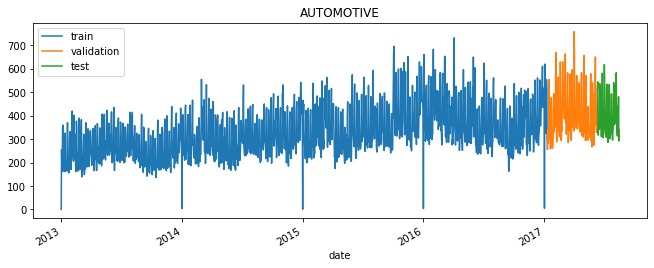

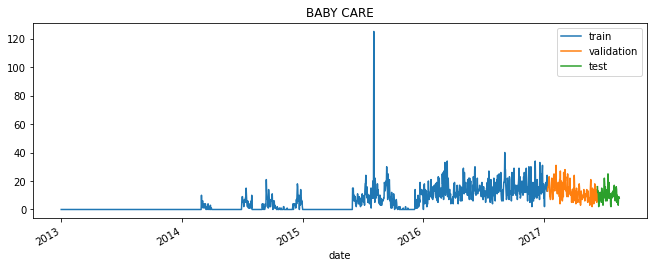

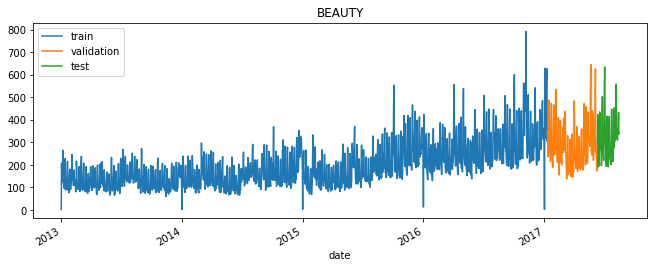

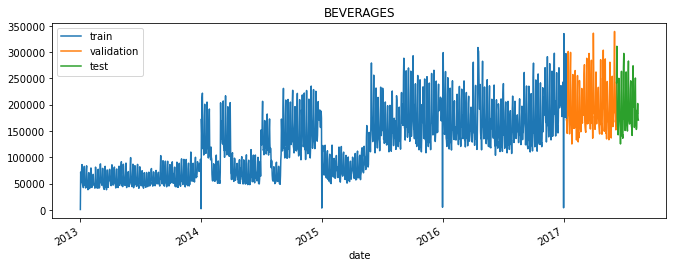

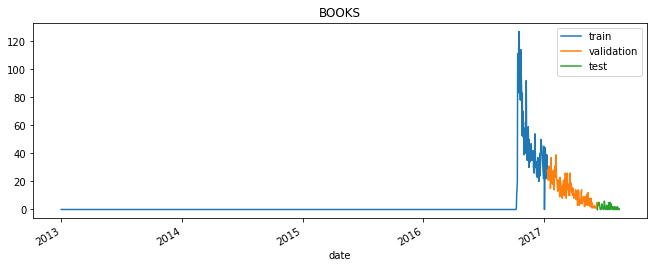

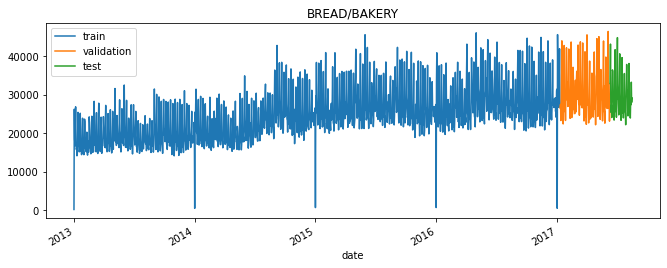

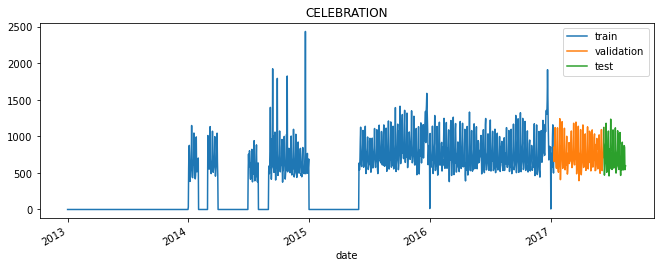

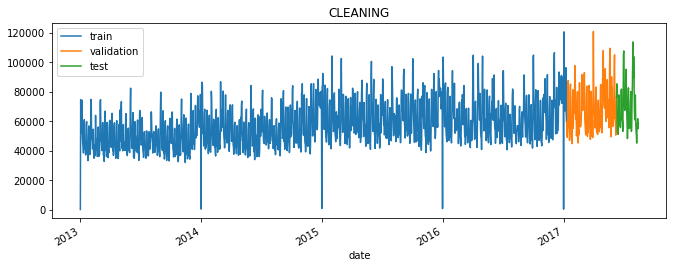

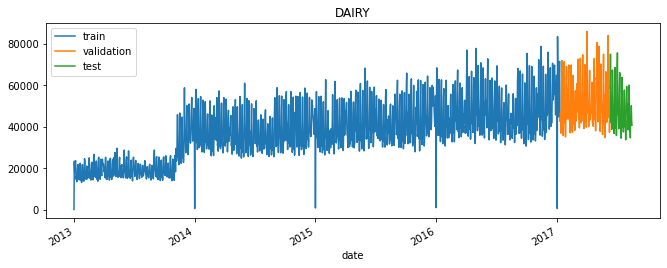

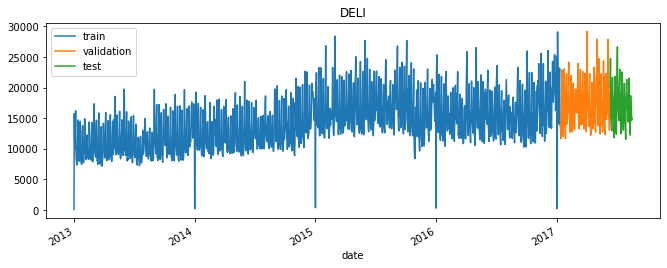

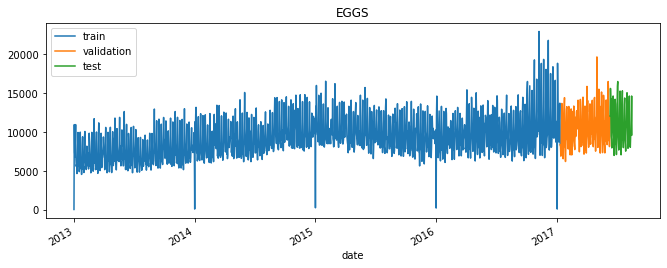

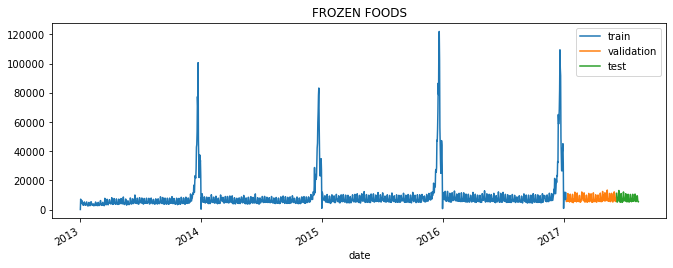

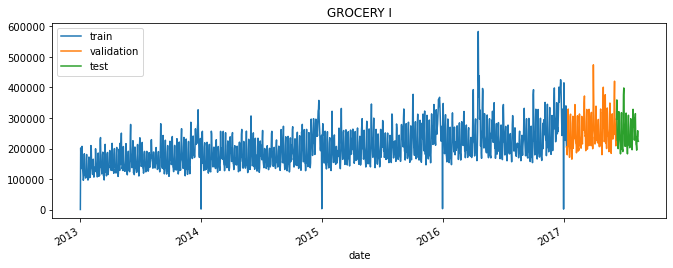

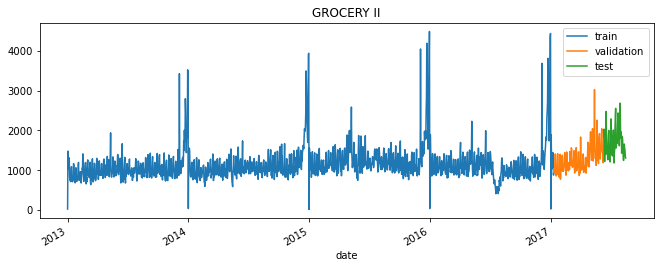

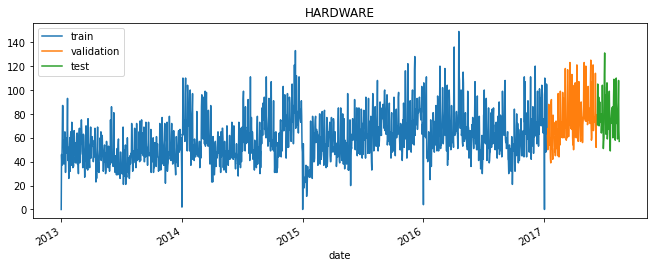

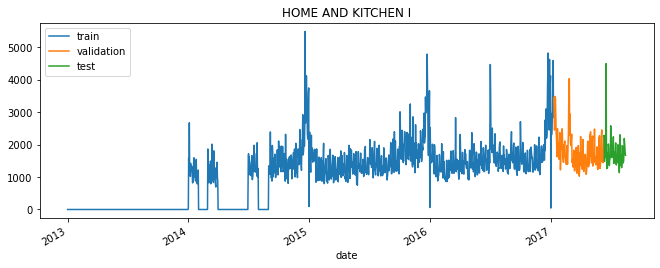

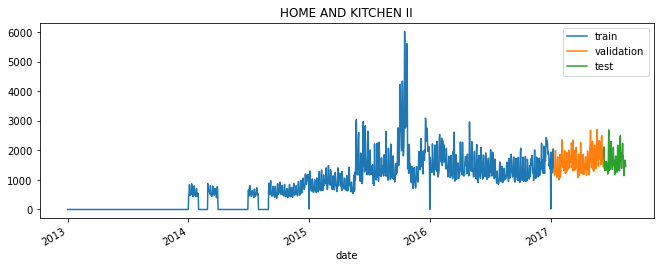

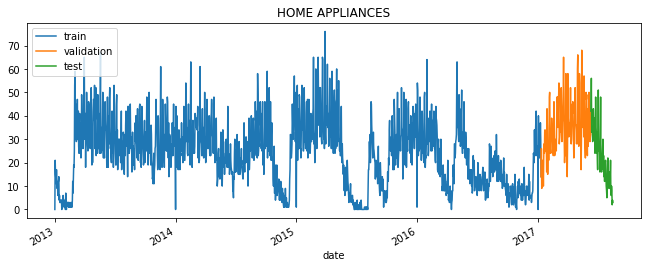

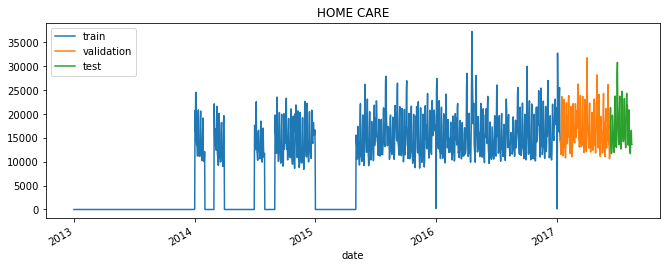

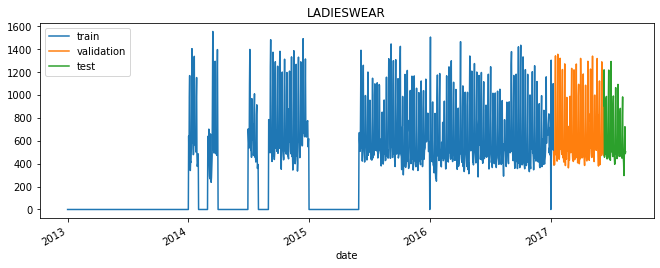

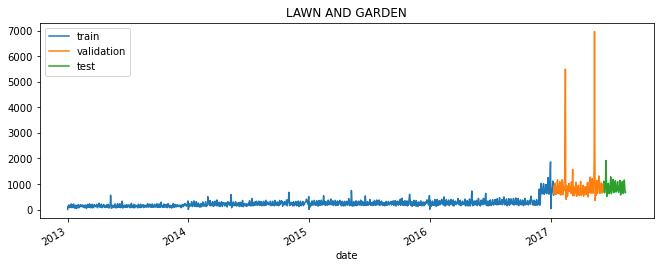

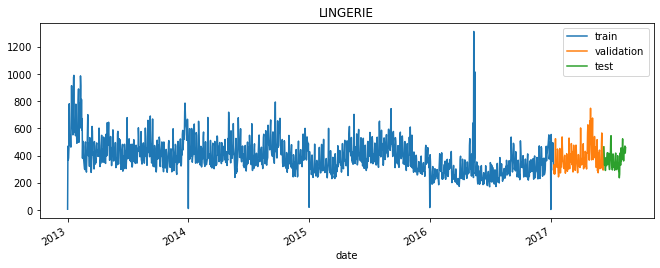

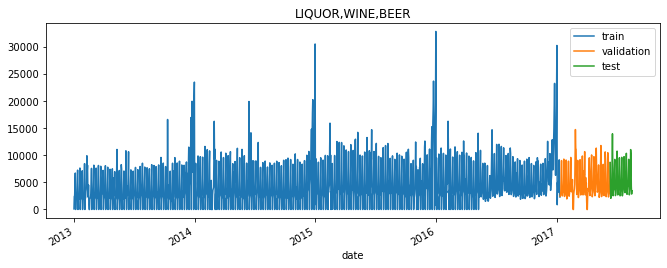

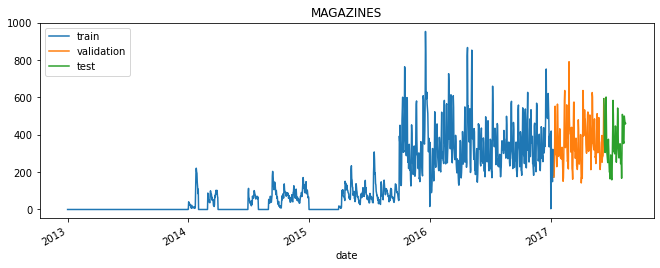

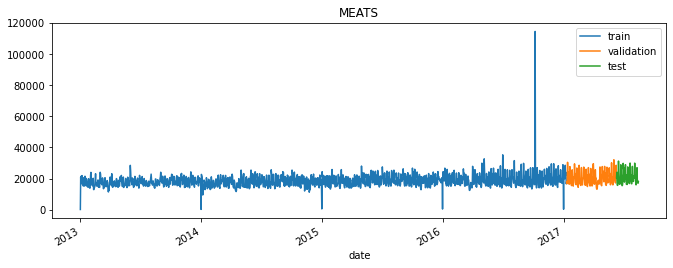

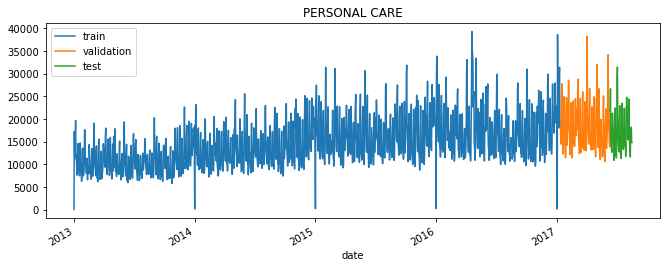

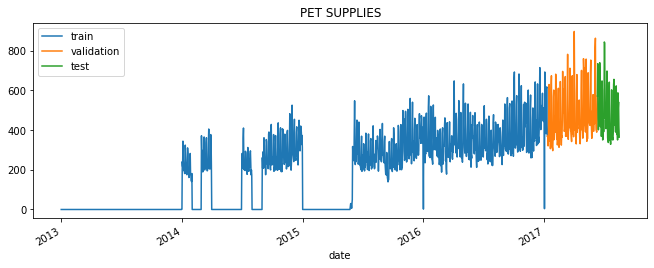

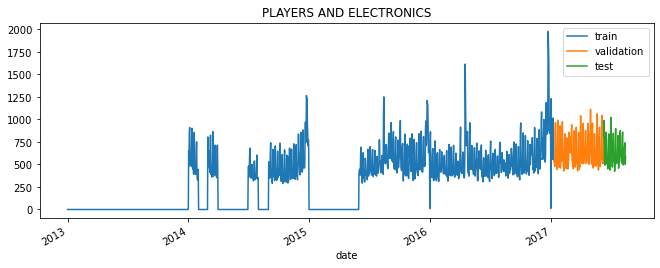

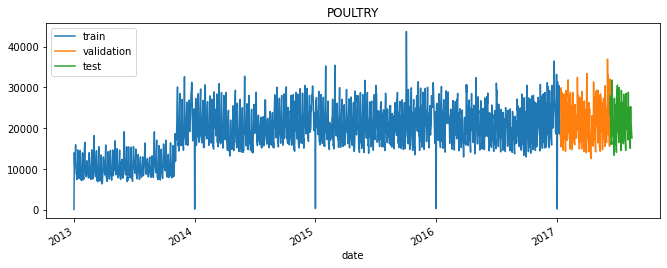

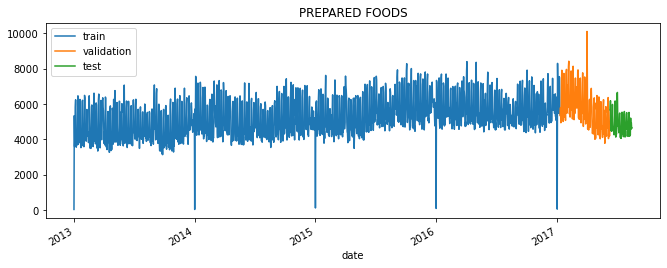

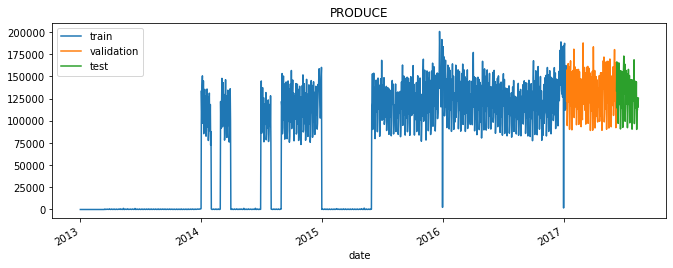

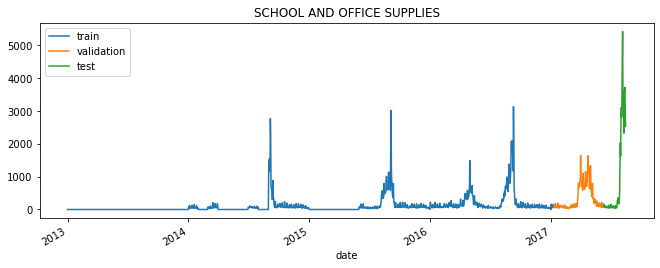

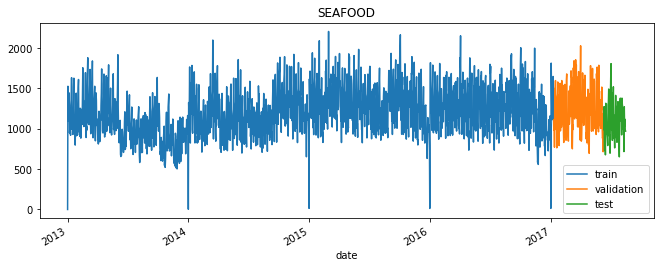

In [25]:
# Plot time series
# ==============================================================================
family_list=data.columns[1:]
for i in family_list:
    fig, ax = plt.subplots(figsize=(11, 4))
    data_train[i].plot(ax=ax, label='train')
    data_val[i].plot(ax=ax, label='validation')
    data_test[i].plot(ax=ax, label='test')
    ax.set_title(i)
    ax.legend();